# Aprendizado Não-Supervisionado - Turma: 030
# Trabalho I - Implementação do DBSCAN
## Integrantes: Pedro N Pagnussat


#### Nota: O algoritmo de DBSCAN faz parte da biblioteca que estou desenvolvendo 'GrimoireML' dispoivivel em: [GrimoireML](https://github.com/PedroNunesPagnussat/GrimoireML/tree/main) eu adptei algumas coisas para poder entregar tudo em um jupyter por isso algumas definições de classe podem parecem *overkill*

### Imports

In [161]:
import numpy as np
import sklearn
from sklearn import datasets
from abc import ABC, abstractmethod
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


### Carregamento de dados

In [162]:
def fetch_data(dataset: str):
    if dataset == "iris":
        return iris()
    elif dataset == "wine":
        return wine()
    elif dataset == "breast_cancer":
        return breast_cancer()
    elif dataset == "mnist":
        return mnist()
    else:
        raise ValueError("Dataset not found")


def iris():
    iris = datasets.load_iris()
    X, y = iris.data, iris.target   

    return X, y


def wine():
    wine = datasets.load_wine()
    X, y = wine.data, wine.target

    return X, y


def breast_cancer():
    breast_cancer = datasets.load_breast_cancer()
    X, y = breast_cancer.data, breast_cancer.target

    return X, y


def mnist():
    mnist = datasets.load_digits()
    X, y = mnist.data, mnist.target

    return X, y


### Definição de Classe de distancias

In [163]:
class DistanceFunction(ABC):
    """This is the base class for all distance functions"""

    @abstractmethod
    def __call__(self, x: np.ndarray, y: np.ndarray) -> float:
        """This method is what calculates the distance between two points"""
        pass
    

    @abstractmethod
    def __str__(self) -> str:
        """This method is called when the function is printed"""
        pass


    def within_range(self, x: np.array, y: np.array, threshold) -> bool:
        """This method checks if the distance between two points is within the threshold"""
        if y.ndim == 1:
            self(x, y) <= threshold

        return np.where(self(x, y) <= threshold, True, False)    


    def distance_matrix(self, x: np.ndarray, y: np.ndarray = None) -> np.ndarray:
        """This method calculates the distance matrix between two sets of points"""

        if y is None:
            y = x

        return np.array([[self(x_i, y_j) for y_j in y] for x_i in x])


In [164]:
class EuclideanDistance(DistanceFunction):
    """This class represents the Euclidian distance function"""

    def __call__(self, x: np.ndarray, y: np.ndarray) -> float:
        """This method is what calculates the distance between two points"""
        if y.ndim == 1:
            return np.linalg.norm(x - y)
        return np.linalg.norm(x - y, axis=1)

    def __str__(self) -> str:
        """This method is called when the function is printed"""
        return "Euclidian Distance"

In [165]:
class ManhattanDistance(DistanceFunction):
    """This class represents the Manhattan Distance function"""

    def __call__(self, x: np.ndarray, y: np.ndarray) -> float:
        """This method is what calculates the distance between two points"""
        if y.ndim == 1:
            return np.sum(np.abs(x - y))
        return np.sum(np.abs(x - y), axis=1)

    def __str__(self) -> str:
        """This method is called when the function is printed"""
        return "Manhattan Distance"

### Codigo do modelo

In [166]:
import numpy as np


class DBSCAN():
    """"This class represents the Density-Based Spatial Clustering of Applications with Noise (DBSCAN) clustering algorithm"""


    class Point:
        """This class represents a point in n-dimensional space"""

        def __init__(self, data: np.ndarray):
            self.data = np.array(data)
            self.cluster = -1
            self.visited = False


        def __str__(self) -> str:
            return str(self.data)
        # distance: float = -1.0
        # noise: bool = False


    def __init__(self, epsilon: float = 0.55, min_points: int = 5, distance_function: DistanceFunction = EuclideanDistance()):
        """This method initializes the DBScan class"""

        self._epsilon = epsilon
        self._min_points = min_points
        self._distance_function = distance_function
        self._points = None
        self._X = None

        self.n_clusters = None
        self.clusters = None


    def fit(self, X: np.ndarray) -> np.ndarray:
        """This method fits the data to the DBScan algorithm"""
        self._X = X
        self._points = np.array([DBSCAN.Point(data) for data in self._X], dtype=DBSCAN.Point)
        self.n_clusters = 0
        self._dbscan()

        return self.clusters


    def _dbscan(self):
        """ This method is the main DBScan algorithm """


        for i, point in enumerate(self._points):
            if point.visited:
                continue

            point.visited = True
            
            mask = self._distance_function.within_range(point.data, self._X, self._epsilon)
            neighbors = self._points[mask]

            # Chck performance and accuracy of this
            neighbors = neighbors[neighbors != point]

            if len(neighbors) < self._min_points:
                continue

            self._expand_cluster(point, neighbors)
            self.n_clusters += 1

        self.clusters = np.array([point.cluster for point in self._points])



    def _expand_cluster(self, point: Point, neighbors: np.ndarray):
        """This spread the cluster to the neighbors of the point, if the points is an central point and the neighbors are not already in a cluster"""
        
        points_to_check = set(neighbors)

        point.cluster = self.n_clusters
        point.visited = True

        while points_to_check:
            neighbor = points_to_check.pop()

            if neighbor.visited:
                continue

            neighbor.visited = True
            neighbor.cluster = self.n_clusters

            neighbor_neighbors_mask = self._distance_function.within_range(neighbor.data, self._X, self._epsilon)
            neighbor_neighbors = self._points[neighbor_neighbors_mask]
            # Chck performance and accuracy of this
            neighbor_neighbors = neighbor_neighbors[neighbor_neighbors != neighbor]

            if len(neighbor_neighbors) >= self._min_points:
                points_to_check.update(neighbor_neighbors)


    def __str__(self) -> str:
        """This method is called when the function is printed"""
        return f"DBScan(epsilon={self._epsilon}, min_points={self._min_points}, distance_function={self._distance_function})"

### Instanciando o modelo

In [167]:
# You can use some toy datasets from sklearn
dataset_name = "iris"
X, y = fetch_data("iris")

# You can also make blobs with sklearn, for example this have 5 clusters and 8 features
# from sklearn.datasets import make_blobs
# X, y = make_blobs(n_samples=10000, centers=5, n_features=8, random_state=0)



#### Hiperpâmetros

In [168]:
eps = 0.55
min_points = 5

##### Hand_made dbscan

In [169]:
from timeit import default_timer as timer

start = timer()
dbscan_handmade = DBSCAN(epsilon=eps, min_points=min_points)
clusters_handmade = dbscan_handmade.fit(X)
end = timer()
handmade_time = end - start


##### Skleand DBSCAN

In [170]:
import sklearn.cluster as skl_cluster

start = timer()
dbscan_sklearn = skl_cluster.DBSCAN(eps=eps, min_samples=min_points)
dbscan_sklearn.fit(X)
clusters_sklearn = dbscan_sklearn.labels_
end = timer()
sklearn_time = end - start

### Resultados

#### Time

In [171]:
print(f"Handmade: {handmade_time}")
print(f"Sklearn: {sklearn_time}")

Handmade: 0.006675800000039089
Sklearn: 0.0021445999999514243


#### Similarity with one another

In [172]:
print(np.unique(clusters_handmade ))
print(np.unique(clusters_sklearn))

[-1  0  1]
[-1  0  1]


In [173]:
similarity = np.mean(clusters_handmade == clusters_sklearn)
print(f"Similarity: {similarity}")

Similarity: 0.98


#### Accuracy

In [174]:
handmade_acc = np.mean(clusters_handmade == y)
sklearn_acc = np.mean(clusters_sklearn == y)
print(f"Accuracy Handmade: {handmade_acc}")
print(f"Accuracy Sklearn: {sklearn_acc}")

Accuracy Handmade: 0.6266666666666667
Accuracy Sklearn: 0.6266666666666667


#### Silhueta

TBM

### Plots

In [175]:
# Function to plot 3D and 2D graphs with legends
def plot_graphs_with_legend(X_transformed: np.ndarray, y_true: np.ndarray, pred1: np.ndarray, pred2: np.ndarray):
    """
    Plots 3D and 2D graphs side by side with legends.
    
    Parameters:
    - X_transformed (np.ndarray): The input data after PCA transformation of shape (n_samples, n_components).
    - y_true (np.ndarray): The true labels of shape (n_samples,).
    - pred1 (np.ndarray): The first set of predicted labels of shape (n_samples,).
    - pred2 (np.ndarray): The second set of predicted labels of shape (n_samples,).
    """
    unique_labels = np.unique(np.concatenate([y_true, pred1, pred2]))
    
    # 3D Plots
    fig = plt.figure(figsize=(18, 6))
    
    ax1 = fig.add_subplot(131, projection='3d')
    for label in unique_labels:
        ax1.scatter(X_transformed[y_true == label, 0], X_transformed[y_true == label, 1], 
                    X_transformed[y_true == label, 2], label=f'Class {label}')
    ax1.set_title('3D Plot - True Labels')
    ax1.legend()
    
    ax2 = fig.add_subplot(132, projection='3d')
    for label in unique_labels:
        ax2.scatter(X_transformed[pred1 == label, 0], X_transformed[pred1 == label, 1], 
                    X_transformed[pred1 == label, 2], label=f'Class {label}')
    ax2.set_title('3D Plot - Predictions 1')
    ax2.legend()
    
    ax3 = fig.add_subplot(133, projection='3d')
    for label in unique_labels:
        ax3.scatter(X_transformed[pred2 == label, 0], X_transformed[pred2 == label, 1], 
                    X_transformed[pred2 == label, 2], label=f'Class {label}')
    ax3.set_title('3D Plot - Predictions 2')
    ax3.legend()
    
    plt.show()
    
    # 2D Plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    for label in unique_labels:
        axs[0].scatter(X_transformed[y_true == label, 0], X_transformed[y_true == label, 1], label=f'Class {label}')
    axs[0].set_title('2D Plot - True Labels')
    axs[0].legend()
    
    for label in unique_labels:
        axs[1].scatter(X_transformed[pred1 == label, 0], X_transformed[pred1 == label, 1], label=f'Class {label}')
    axs[1].set_title('2D Plot - Predictions 1')
    axs[1].legend()
    
    for label in unique_labels:
        axs[2].scatter(X_transformed[pred2 == label, 0], X_transformed[pred2 == label, 1], label=f'Class {label}')
    axs[2].set_title('2D Plot - Predictions 2')
    axs[2].legend()
    
    plt.show()



In [176]:
def perform_pca(X: np.ndarray, n_components: int = 3) -> np.ndarray:
    """
    Performs PCA on the input data to reduce its dimensions.
    
    Parameters:
    - X (np.ndarray): The input data of shape (n_samples, n_features).
    - n_components (int): The number of principal components to reduce to.
    
    Returns:
    - np.ndarray: The transformed data of shape (n_samples, n_components).
    """
    pca = PCA(n_components=n_components)
    X_transformed = pca.fit_transform(X)
    return X_transformed


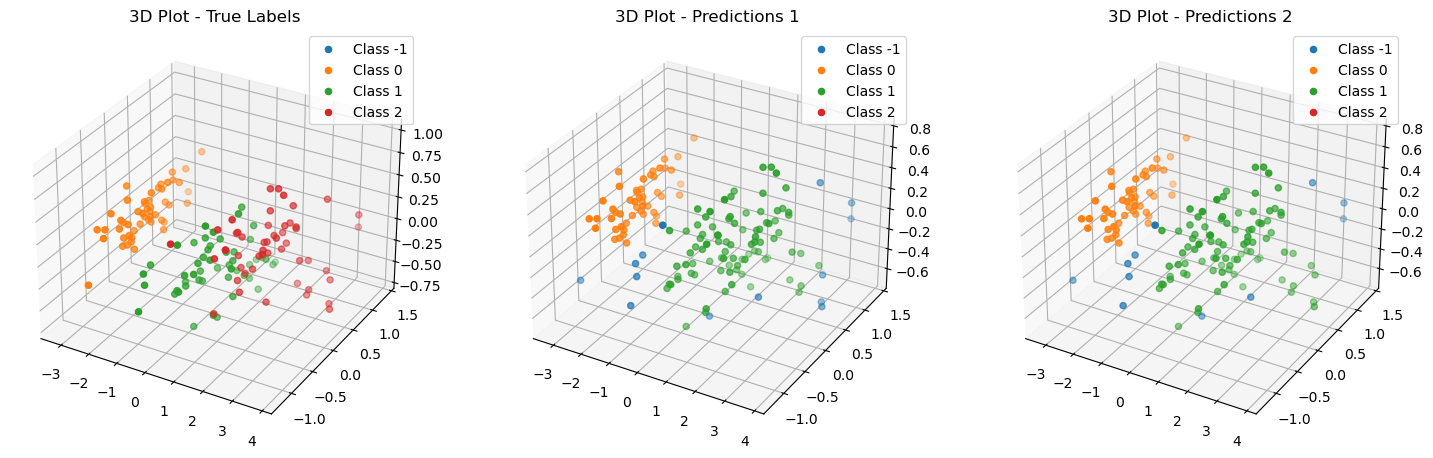

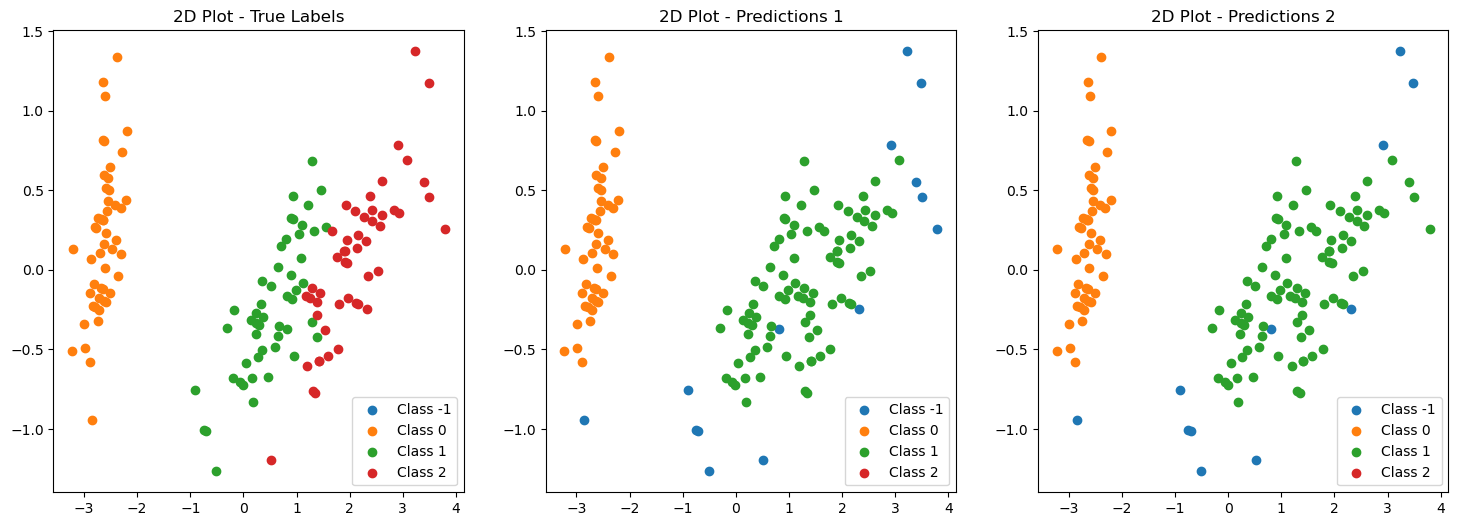

In [177]:
X_transformed = perform_pca(X)
plot_graphs_with_legend(X_transformed, y, clusters_handmade, clusters_sklearn)